<a href="https://colab.research.google.com/github/StillWork/ds_LS_530/blob/master/hh_%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B9%84%EA%B5%90_190812_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os, os.path, shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def rmse(y, y_pred):
  return np.sqrt(((y - y_pred)**2).mean())

In [0]:
# 시퀀스 데이터를 X, y로 나누는 함수 정의 (하나씩 슬라이딩, 다음샘플 예측)
def split_sequence_slide_next(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
     break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

# non overlapping, next window 예측의 경우
def split_sequence_nonOL_next_window(sequence, n_steps):
  X, y = list(), list()
  for i in range(0,len(sequence),n_steps):
    end_ix = i + n_steps -1
    if end_ix > len(sequence)-n_steps-1:
      break
    seq_x, seq_y = sequence[i:end_ix+1], sequence[end_ix+n_steps]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [0]:
result = dict()

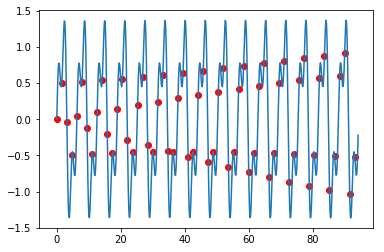

In [295]:
# 사인파 생성
# 전체 싸이클 수
cy = 60
# 싸이클 당 sample 수
sample = 4
# 원본 아날로그 사인파 그리기 (배경) 10배 상세히 그리기
xx= np.linspace(0, 2*np.pi*cy,cy*sample*10)
yy = np.sin(xx) - 0.3*np.sin(2*xx) + 0.5*np.sin(3*xx) #+ 0.1*np.random.randn(cy*sample*10)

# 디지털 샘플
xs= np.linspace(0, 2*np.pi*cy,cy*sample)
ys = np.sin(xs) - 0.3*np.sin(2*xs) + 0.5*np.sin(3*xs) #+ 0.1*np.random.randn(cy*sample)

# 앞의 60개만 그려보기
# plt.plot(xx,yy)
# plt.scatter(xs,ys, c='r')
plt.plot(xx[:600],yy[:600])
plt.scatter(xs[:60],ys[:60], c='r')

In [0]:
sequence = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
n_steps = 3
X, y = split_sequence_slide_next(sequence,n_steps)
X,y

(array([[ 0,  1,  2],
        [ 1,  2,  3],
        [ 2,  3,  4],
        [ 3,  4,  5],
        [ 4,  5,  6],
        [ 5,  6,  7],
        [ 6,  7,  8],
        [ 7,  8,  9],
        [ 8,  9, 10],
        [ 9, 10, 11],
        [10, 11, 12],
        [11, 12, 13]]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

In [0]:
X, y = split_sequence_nonOL_next_window(sequence,8)
X,y

(array([], dtype=float64), array([], dtype=float64))

In [0]:
n_steps = 20
X, y = split_sequence_nonOL_next_window(ys,n_steps)
# X, y = split_sequence_slide_next(ys,n_steps)

In [0]:
X.shape, y.shape

((380, 20), (380,))

## 퍼시스턴스 모델

### 훈련데이터, 검증데이터

In [0]:
x_train = X
x_test = X[:200]
y_train = y
y_test = y[:200]
x_train.shape, x_test.shape

((17, 20), (17, 20))

In [0]:
y_train.shape, y_test.shape

((17,), (17,))

###  퍼시스턴스 예측

In [0]:
y_pred = x_test[:,n_steps-1]

ValueError: ignored

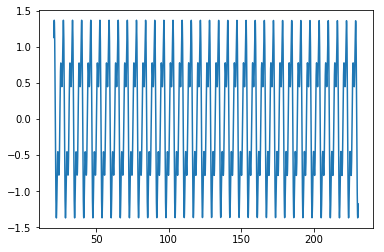

In [0]:
plt.plot(xx[200:2200],yy[200:2200])

plt.scatter(xs[20:220],y_test)
plt.scatter(xs[20:220],y_pred, c='r')

In [0]:
result['persistent_'+str(sample)]= rmse(y_test, y_pred)
result

{'persistent_6': 1.3088804412607378}

## 선형모델

In [0]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(x_train,y_train)

In [0]:
y_pred = lr.predict(x_test)

In [0]:
result['linear_'+str(sample)]= rmse(y_test, y_pred)
result

{'linear_6': 4.10002643708844e-16, 'persistent_6': 1.3088804412607378}

##  MLP

In [0]:
model = Sequential()
model.add(Dense(100,activation = 'relu',input_shape = (n_steps,)))
model.add(Dense(1))
model.compile(optimizer='Adam',loss= 'mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 101       
Total params: 2,201
Trainable params: 2,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x_train,y_train,epochs=200, verbose=0)

In [0]:
y_pred = model.predict(x_test)
result['MLP_'+str(sample)]=  rmse(y_test, y_pred.ravel())
result

{'MLP_6': 0.006817011148388494,
 'linear_6': 4.10002643708844e-16,
 'persistent_6': 1.3088804412607378}

## LSTM

In [0]:
x_train = x_train.reshape(-1, x_train.shape[1],1)
x_test = x_test.reshape(-1, x_test.shape[1],1)

In [0]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from keras.layers import LSTM
from keras.layers import Dense
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)

model = Sequential()
model.add(LSTM(10,activation = 'relu',input_shape = (n_steps,1)))
model.add(Dense(1))

model.compile(optimizer='Adam',loss= 'mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train,y_train,epochs=200, verbose=0)
#                    callbacks =[es])

In [0]:
y_pred = model.predict(x_test)

In [0]:
result['LSTM_'+str(sample)]=  rmse(y_test, y_pred.ravel())
result

{'LSTM_6': 0.1663584850150007,
 'MLP_6': 0.006817011148388494,
 'linear_6': 4.10002643708844e-16,
 'persistent_6': 1.3088804412607378}

In [0]:
res_6 = result

In [0]:
res_20 = result

In [0]:
res_6

{'LSTM_6': 0.1663584850150007,
 'MLP_6': 0.006817011148388494,
 'linear_6': 4.10002643708844e-16,
 'persistent_6': 1.3088804412607378}

In [0]:
res_20

{'LSTM_20': 0.020208353178281,
 'MLP_20': 0.001005161594565951,
 'linear_20': 3.8061705000169755e-15,
 'persistent_20': 0.4125501540564566}